# $Explore$ $Zillow$

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w

In [2]:
# wrangel zillow data
df = w.wrangle_single_family_residential()

In [3]:
# shape of data after dropping NAN and Nulls
df.shape

(2140235, 7)

### 2 Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [4]:
# Split data to train , test validate, using random state 123
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [5]:
# shape of train
train.shape

(1203882, 7)

In [6]:
# firs look at train data
train.head()

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips
224259,2.0,1.0,816.0,254857.0,1971.0,3398.38,6059.0
1705335,4.0,2.0,2214.0,234181.0,1925.0,2936.04,6037.0
1374808,3.0,2.0,1254.0,280667.0,1955.0,3472.40,6037.0
1151859,4.0,3.0,2722.0,577348.0,1981.0,6847.34,6037.0
1676467,2.0,2.5,2986.0,509543.0,1981.0,5621.72,6059.0


In [7]:
# stats in zillow train set
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,1203882.0,3.301874,0.932598,0.00,3.00,3.000,4.00,18.0
bathroom,1203882.0,2.241293,0.991194,0.00,2.00,2.000,3.00,32.0
squarefeet,1203882.0,1864.348798,1388.209889,1.00,1258.00,1624.000,2209.00,952576.0
tax_value,1203882.0,460814.471111,684702.029115,22.00,189392.00,328614.000,534839.50,88020448.0
yearbuilt,1203882.0,1960.980583,22.143171,1801.00,1949.00,1958.000,1976.00,2016.0
taxamount,1203882.0,5619.525541,7900.934584,13.36,2541.88,4115.095,6411.63,1052070.5
fips,1203882.0,6048.313604,20.347666,6037.00,6037.00,6037.000,6059.00,6111.0


In [8]:
# name of columns in train
train.columns

Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips'],
      dtype='object')

In [9]:
train.fips.value_counts()

6037.0    801542
6059.0    310633
6111.0     91707
Name: fips, dtype: int64

fips will be taken out because it is a county code 


In [10]:
train['age'] = 2017-train.yearbuilt

In [11]:
sample= train.sample(1_000, random_state=123)

In [12]:
# columns of interest as potenital usage in model
columns = ['bedroom', 'bathroom', 'squarefeet', 'yearbuilt',
       'taxamount','tax_value','age']

In [13]:
# correaltion between variables
zillow_corr = train.corr(method='spearman')
zillow_corr

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
bedroom,1.000000,0.634604,0.656083,0.295919,0.425811,0.297343,0.176879,-0.425811
bathroom,0.634604,1.000000,0.826096,0.481934,0.569801,0.481631,0.184154,-0.569801
squarefeet,0.656083,0.826096,1.000000,0.523300,0.511698,0.520866,0.185459,-0.511698
tax_value,0.295919,0.481934,0.523300,1.000000,0.289913,0.978606,0.149916,-0.289913
yearbuilt,0.425811,0.569801,0.511698,0.289913,1.000000,0.288402,0.413078,-1.000000
taxamount,0.297343,0.481631,0.520866,0.978606,0.288402,1.000000,0.085144,-0.288402
fips,0.176879,0.184154,0.185459,0.149916,0.413078,0.085144,1.000000,-0.413078
age,-0.425811,-0.569801,-0.511698,-0.289913,-1.000000,-0.288402,-0.413078,1.000000


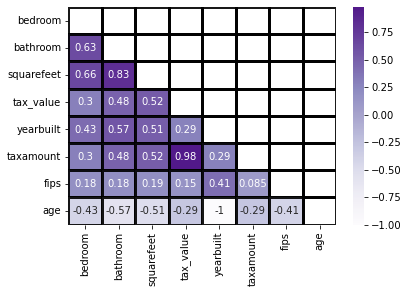

In [14]:
# pass my correlation matrix to Seaborn's heatmap 
kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black'}

sns.heatmap(zillow_corr, cmap='Purples', annot=True, 
            mask=np.triu(zillow_corr), **kwargs)
plt.show()

The strongest correlation is tax_value and taxamount at 0.98
The strongest correlation is squarefeet vs bathrooms at 0.83

* Next strongest is  squarefeet vs bedrooms at 0.66
* Next  strongest is  bathroom vs bedroom at 0.63
* Others above 0.5:
        * yearbuild(age) vs bathrooms at 0.57
        * taxammount vs squarefeet at 0.52
        * year built(age) vs squarefeet at 0.51
        
The **target is tax_value** has a strong correlation with taxamount (0.98), and a correlation of (0.52) with squarefeet 
        

In [15]:
X = train[[ 'yearbuilt',
       'taxamount','bedroom']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,yearbuilt,13.970850
1,taxamount,1.612169
2,bedroom,14.871597


In [16]:
X = train[['bedroom', 'bathroom', 'squarefeet' ,
       'taxamount','age' ]]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,bedroom,17.491667
1,bathroom,15.471204
2,squarefeet,4.446587
3,taxamount,2.105021
4,age,4.040794


In [30]:
X = train[[ 'squarefeet' ,
       'taxamount','age']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,squarefeet,2.596016
1,taxamount,1.824812
2,age,1.858235


### might use these features for model since the combination had the most independence 
* 'squarefeet' ,'taxamount','bedroom'
* 'squarefeet' ,'taxamount','age'

### Maybe these features but there is a vif score above 5 in (bedroom/bathroom)
* 'squarefeet' , 'taxamount','age', 'bedroom'(7.22)
* 'squarefeet' , 'taxamount','age', 'bathroom'(6.38)

### 3.  Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [18]:
# how to create a list from train columns
col = train.columns.to_list()

### reverse the columns
col.reverse()

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203882 entries, 224259 to 1032115
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedroom     1203882 non-null  float64
 1   bathroom    1203882 non-null  float64
 2   squarefeet  1203882 non-null  float64
 3   tax_value   1203882 non-null  float64
 4   yearbuilt   1203882 non-null  float64
 5   taxamount   1203882 non-null  float64
 6   fips        1203882 non-null  float64
 7   age         1203882 non-null  float64
dtypes: float64(8)
memory usage: 82.7 MB


In [20]:
def plot_variable_pair(df):
    columns = df.columns.to_list()
    for i, col in enumerate(columns):
        sns.lmplot(data=df, x=col, y='tax_value', line_kws={'color':'red'})
        plt.show()

def plot_variable_pair1(df):
    columns = df.columns.to_list()
    for i, col in enumerate(columns):
        subplot_number = i + 1
        plt.subplot(1,4,subplot_number)
        plt.title(col)
        sns.lmplot(data=df, x=df[col], y='tax_value', line_kws={'color':'red'})
        plt.show()

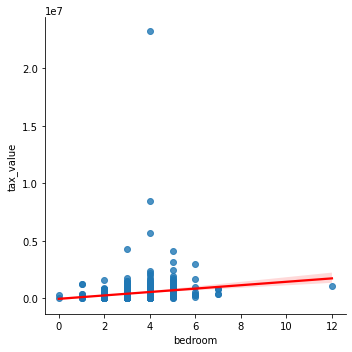

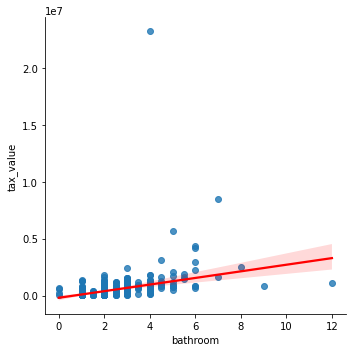

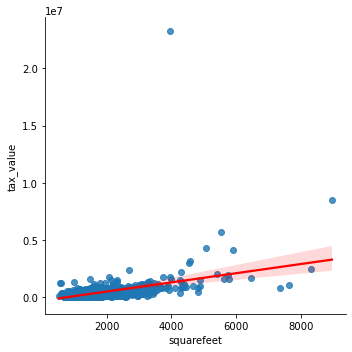

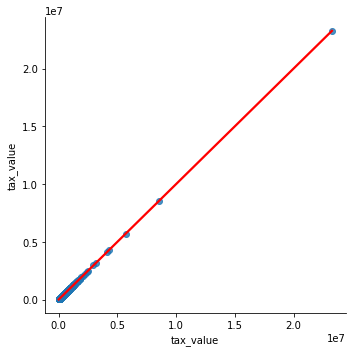

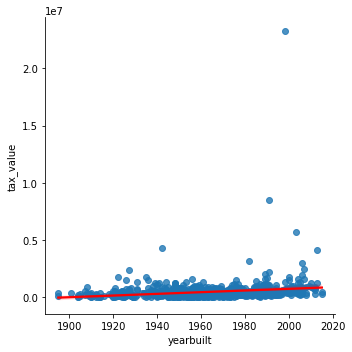

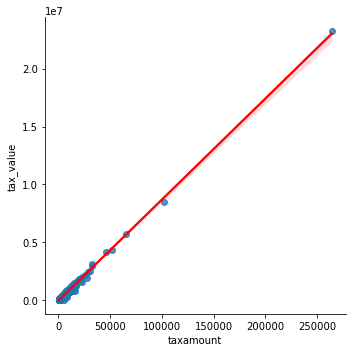

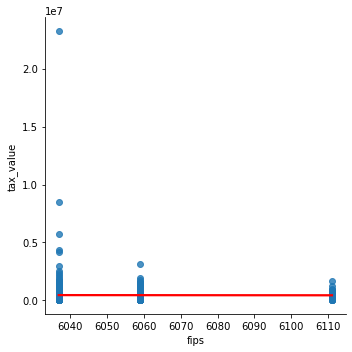

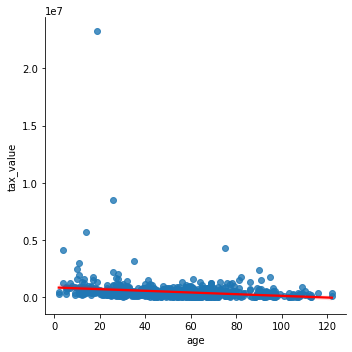

In [21]:
plot_variable_pair(sample)

In [22]:
sns.jointplot(data=train, x='bedroom', y='tax_value', kind='reg')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x13d566dc0> (for post_execute):


KeyboardInterrupt: 

Normal distribution, linear function has a positive slope close to 0.

In [ ]:
sns.jointplot(data=train, x='bathroom', y='tax_value', kind='reg')

normal distribution, slope is positive

In [ ]:
sns.jointplot(data=train, x='squarefeet', y='tax_value', kind='reg')

In [ ]:
Outliers are skewing the data here

In [ ]:
sns.jointplot(data=train, x='yearbuilt', y='tax_value', kind='reg')

line has a slope close to 0

In [ ]:
sns.jointplot(data=train, x='taxamount', y='tax_value', kind='reg')

Strong positive correlation, outliers are present but doent seem to skew at this axis scale

In [ ]:
sns.jointplot(data=train, x='age', y='tax_value', kind='reg')

Slope is close to 0

In [ ]:
sns.pairplot(data=train.drop(columns='fips'),
            corner=True,kind='reg')
plt.show()

### 4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [23]:
sample.dtypes

bedroom       float64
bathroom      float64
squarefeet    float64
tax_value     float64
yearbuilt     float64
taxamount     float64
fips          float64
age           float64
dtype: object

In [24]:
train.fips = train.fips.astype(object)

In [26]:
train.bedroom = train.bedroom.astype(object)

In [27]:
train.bathroom = train.bedroom.astype(object)

In [28]:
sample= train.sample(1_000, random_state=123)

In [29]:
train.dtypes

bedroom        object
bathroom       object
squarefeet    float64
tax_value     float64
yearbuilt     float64
taxamount     float64
fips           object
age           float64
dtype: object

In [31]:
def plot_categorical_and_continuous_vars(df, cat, cont):

    plt.title(cat, cont)
    
    sns.boxplot(x = df[cat], y = df[cont])
    sns.barplot(x = df[cat], y = df[cont])
    sns.violinplot(x=df[cat], y=df[cont])
    
    

In [48]:
cat_vars = ['bathroom', 'bedroom', 'fips']
cont_vars = ['taxamount', 'tax_value', 'yearbuilt','age']

In [49]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()


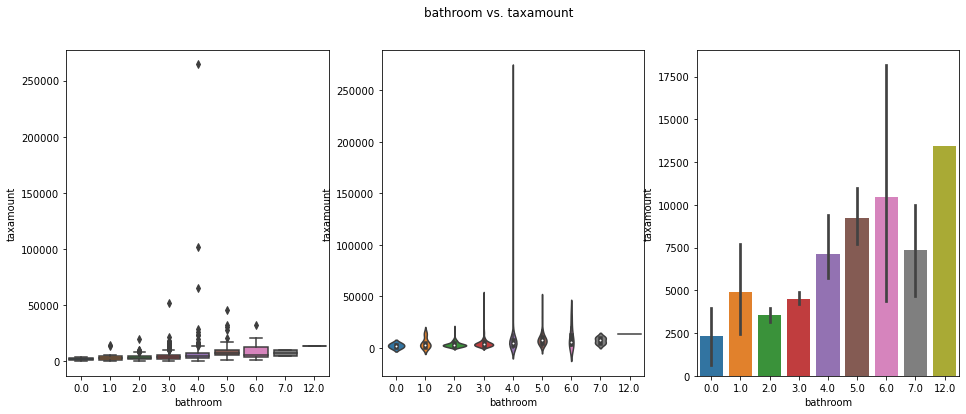

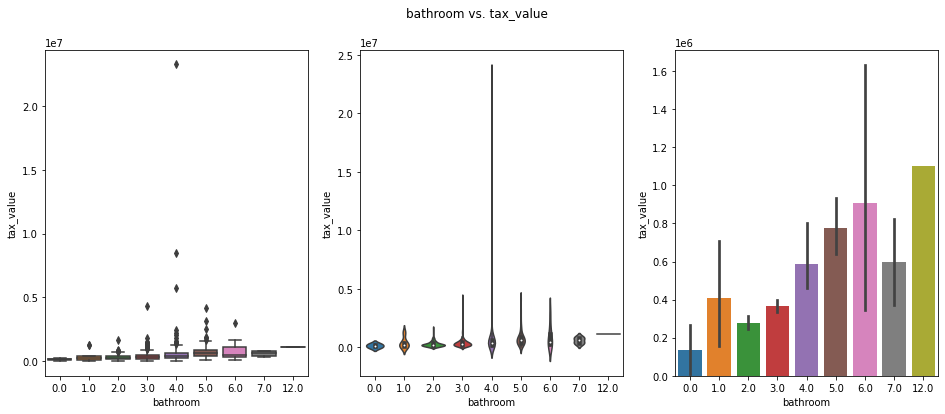

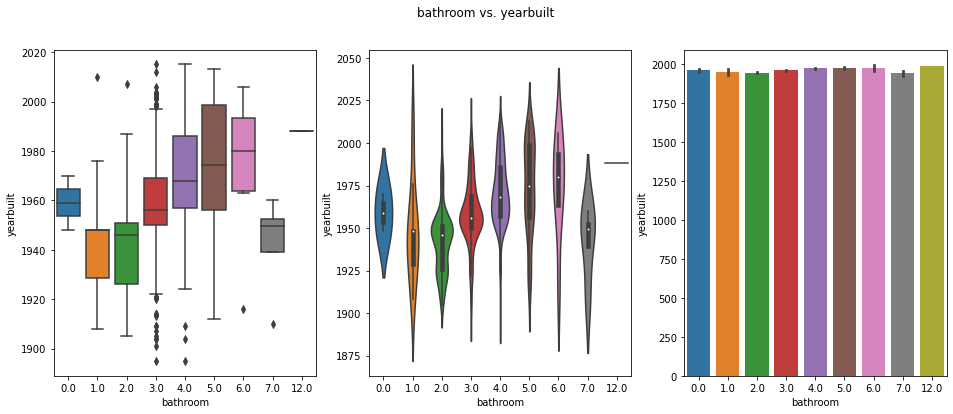

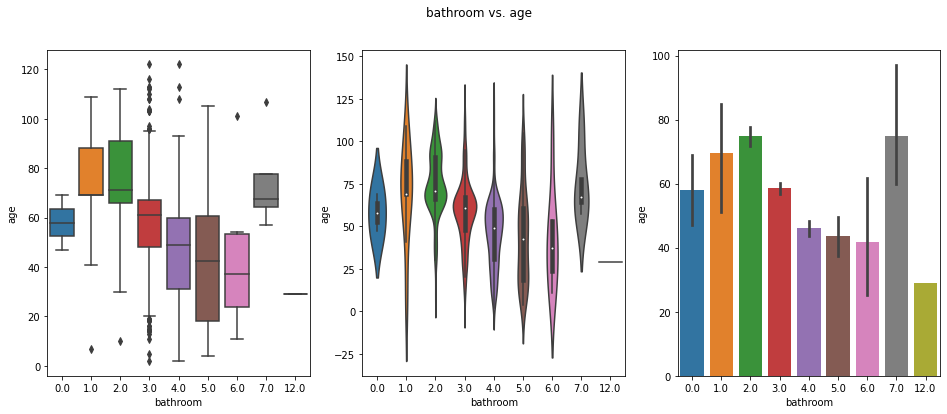

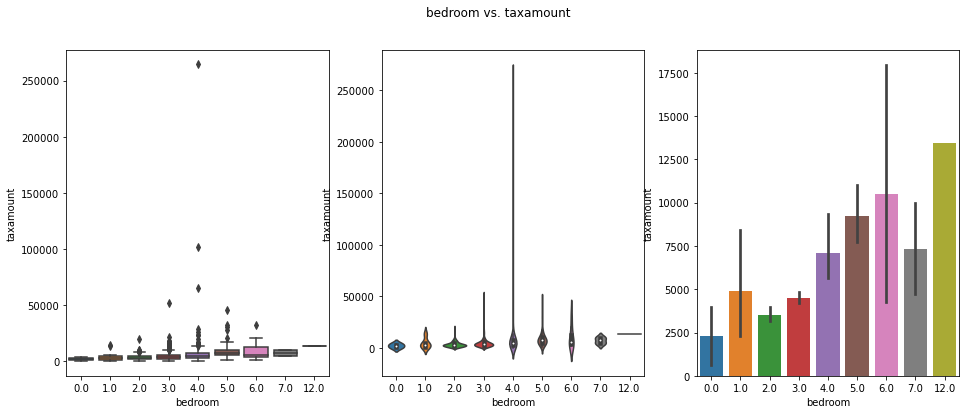

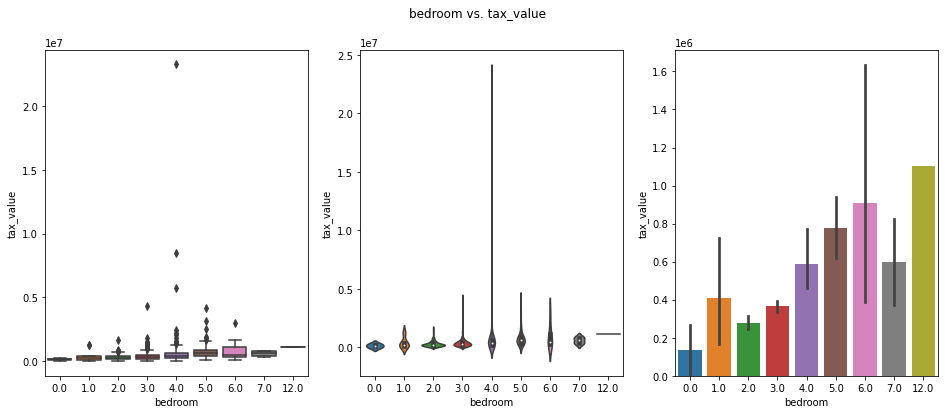

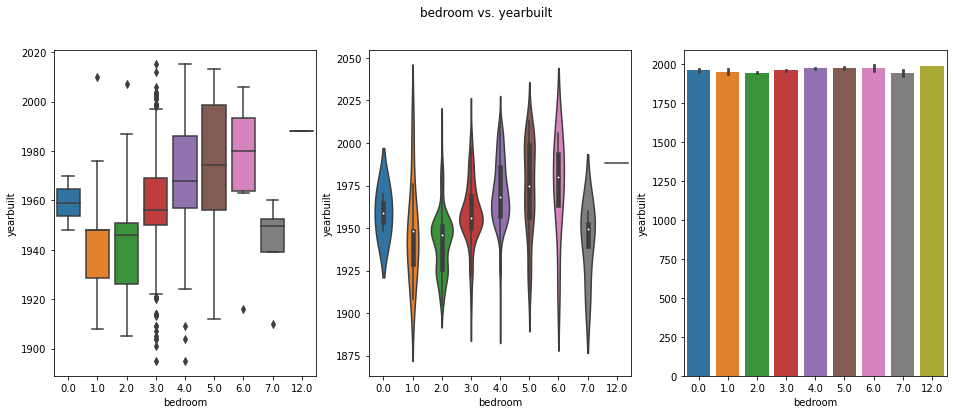

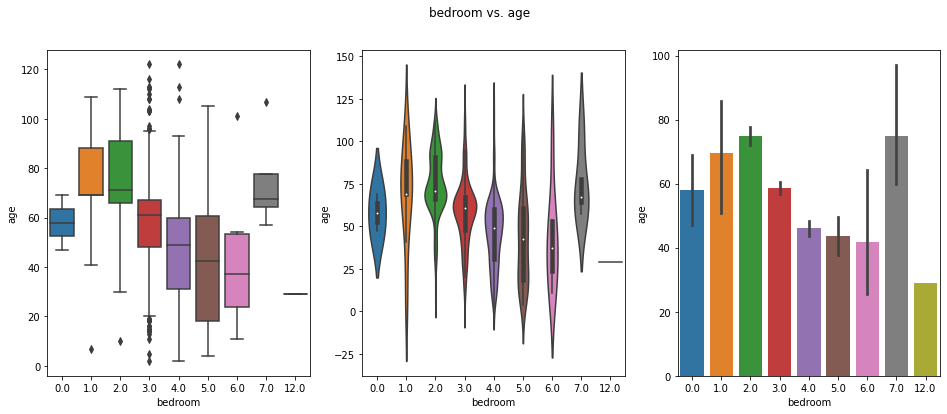

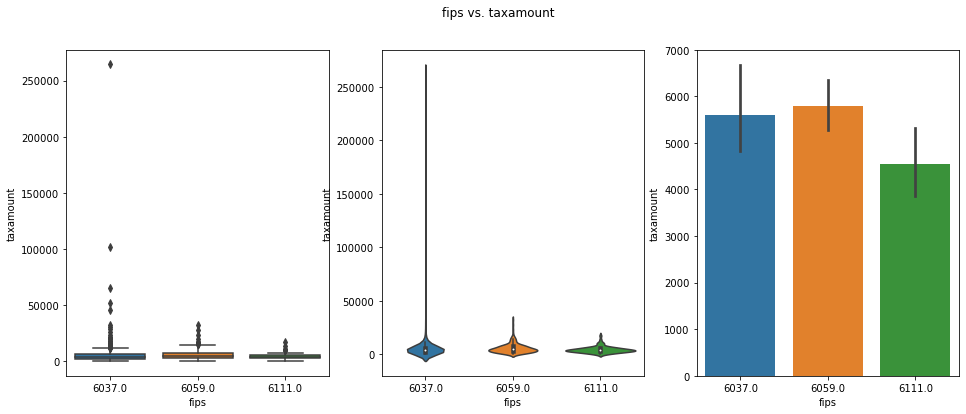

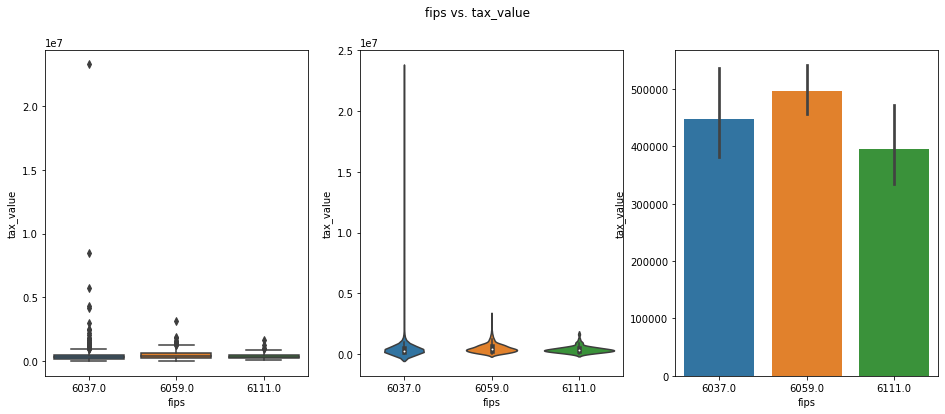

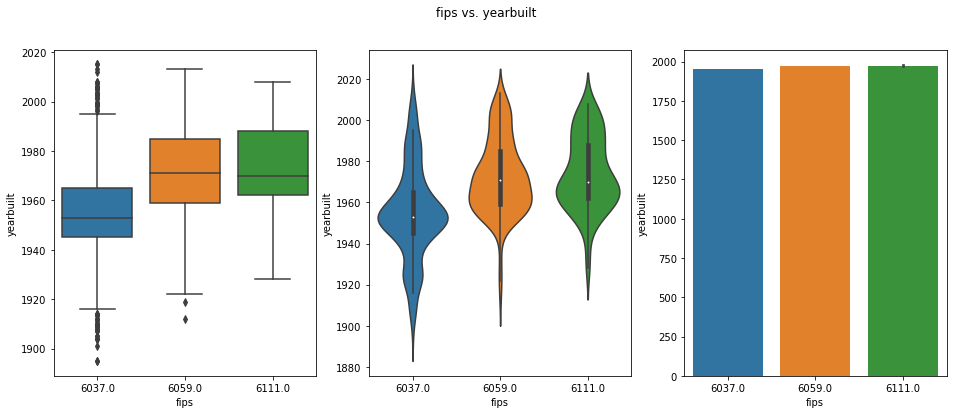

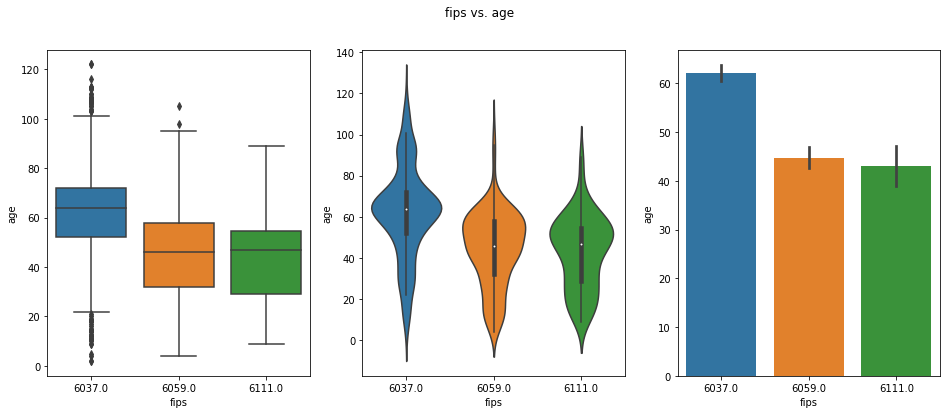

In [51]:
plot_categorical_and_continuous_vars(sample,cat_vars, cont_vars)

In [39]:
sample.columns.is_object

<bound method Index.is_object of Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips', 'age'],
      dtype='object')>

In [ ]:
sns.boxplot(x = sample.bedroom, y = sample.tax_value)

In [ ]:
sns.barplot(x = sample.bedroom, y = sample.tax_value)

In [ ]:
sns.violinplot(x=sample.bedroom, y=sample.tax_value)

In [ ]:
plot_categorical_and_continuous_vars(train, 'bedroom', 'tax_value')

In [ ]:
for i, col in enumerate(cols):
    # i starts at 0, but plot nos should start at 1
    subplot_num = i+1
    # Create subplot.
    plt.subplot(1,4,subplot_num)
    # Title with column name.
    plt.title(col)
    # Display histogram for column.
    sns.boxplot(y = '', x = 'species', data = iris)
    # Hide gridlines.
    plt.grid(False)

### 5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

In [63]:
for i in cat_vars:
    corr, p = stats.pearsonr(sample[i], sample.tax_value)
    print(f'{i} correlation {corr}, p-val{p}')

bathroom correlation 0.16322037593239133, p-val2.104443596345294e-07
bedroom correlation 0.16322037593239133, p-val2.104443596345294e-07
fips correlation -0.0048032453288262, p-val0.8794213054012673


In [62]:
for i in cat_vars:
    corr, p = stats.spearmanr(sample[i], sample.tax_value)
    print(f'{i} correlation {corr}, p-val{p}')

bathroom correlation 0.31929419323729014, p-val3.904649105565349e-25
bedroom correlation 0.31929419323729014, p-val3.904649105565349e-25
fips correlation 0.1451626888140743, p-val4.043378357106685e-06


In [60]:
for i in cont_vars:
    corr, p = stats.pearsonr(sample[i], sample.tax_value)
    print(f'{i} correlation {corr}, p-val{p}')

taxamount correlation 0.9972484206936493, p-val0.0
tax_value correlation 0.9999999999999987, p-val0.0
yearbuilt correlation 0.1894223270868745, p-val1.5670799954855951e-09
age correlation -0.1894223270868749, p-val1.5670799954854115e-09
